In [17]:
import numpy as np 
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import glob
from tqdm import tqdm
from collections import OrderedDict, defaultdict
from IPython.display import clear_output
import time
import torch
import torch.nn as nn
import torch.optim as optim

In [18]:
eating_data=[]

In [19]:
dir = os.getcwd() + "/clips_eating/extracted_points/"
files = glob.glob(dir + "*.txt")
for file in files:
    file = open(file, 'r')
    lines = np.loadtxt(file, dtype=str)
    ret=[]
    for line in lines:
        frame=[]
        vals = line.split(',')
        for val in vals:
            convert = float(val)
            frame.append(convert)
        ret.append(frame)
    r = np.array(ret)
    eating_data.append(r)


In [20]:
# dir = os.getcwd() + "/eating_clips/extracted_points/"
# files = glob.glob(dir + "*.txt")
# for file in files:
#     file = open(file, 'r')
#     lines = np.loadtxt(file, dtype=str)
#     ret=[]
#     for line in lines:
#         frame=[]
#         vals = line.split(',')
#         for val in vals:
#             convert = float(val)
#             frame.append(convert)
#         ret.append(frame)
#     r = np.array(ret)
#     eating_data.append(r)

# len(eating_data)

In [21]:
lengths=[len(data) for data in eating_data]
np.min(lengths), np.max(lengths) , np.mean(lengths)

(21, 86, 41.45132743362832)

In [22]:
max_length=30
eating_data2=[]
for data in eating_data:
    if len(data)>=max_length:
        eating_data2.append(data[:max_length])

len(eating_data2)

102

In [23]:
dir = os.getcwd() + "/non_eating_clips/extracted_points/"
files = glob.glob(dir + "*.txt")
noneating_data=[]
for file in files:
    file = open(file, 'r')
    lines = np.loadtxt(file, dtype=str)
    ret=[]
    for line in lines:
        frame=[]
        vals = line.split(',')
        for val in vals:
            convert = float(val)
            frame.append(convert)
        ret.append(frame)
    r = np.array(ret)
    print(r.shape)
    noneating_data.append(r)
len(noneating_data)

(3474, 50)
(3461, 50)


2

In [24]:
noneating_data2=[]
for i in range(20):
    noneating_data2.append(noneating_data[0][i*max_length: i*max_length+max_length])
    noneating_data2.append(noneating_data[1][i*max_length: i*max_length+max_length])

len(noneating_data2)

40

In [25]:
X=np.concatenate([eating_data2, noneating_data2])
y=np.ones(len(X))
y[len(eating_data2):]=0

X.shape, y.shape

((142, 30, 50), (142,))

In [26]:
X=torch.from_numpy(X).float()
y=torch.from_numpy(y).reshape(-1,1)
X.shape, y.shape

(torch.Size([142, 30, 50]), torch.Size([142, 1]))

In [27]:
ids=np.arange(X.shape[0])
np.random.shuffle(ids)
train_ids=ids[:int(len(ids)*0.8)]
test_ids=ids[int(len(ids)*0.8):]
X_train, y_train=X[train_ids], y[train_ids]
X_test, y_test=X[test_ids], y[test_ids]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([113, 30, 50]),
 torch.Size([113, 1]),
 torch.Size([29, 30, 50]),
 torch.Size([29, 1]))

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [29]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num, seq_len):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(seq_len)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [59]:
import random
n_data_size_train = X_train.shape[0]
n_data_size_test = X_test.shape[0]

def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = X_train
        y = y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = X_test
        y = y_test
        data_size = n_data_size_test
    if num == -1:
        ran_num = random.randint(0,data_size-batch_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num+batch_size,:]
    return category_tensor.long(),pose_sequence_tensor

In [31]:
n_hidden = 128
n_joints = 25*2
n_categories = 2
n_layer = 3
seq_len = 30
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer, seq_len)
rnn.to(device)

LSTM(
  (lstm): LSTM(50, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [32]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

In [33]:
n_iters = 20000
print_every = 1000
plot_every = 1000
batch_size = 4

# Keep track of losses for plotting
current_loss = 0
all_losses = []

 
start = time.time()

for iter in range(1, n_iters + 1):
   
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    
    optimizer.zero_grad()
    
    output = rnn(input_sequence)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step() 
 
    current_loss += loss.item()

    print('iter: %d, loss: %.3f' % (iter, loss.item()))
    
    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

iter: 1, loss: 0.691
iter: 2, loss: 0.685
iter: 3, loss: 0.681
iter: 4, loss: 0.681
iter: 5, loss: 0.687
iter: 6, loss: 0.689
iter: 7, loss: 0.686
iter: 8, loss: 0.686
iter: 9, loss: 0.700
iter: 10, loss: 0.679
iter: 11, loss: 0.686
iter: 12, loss: 0.697
iter: 13, loss: 0.672
iter: 14, loss: 0.683
iter: 15, loss: 0.693
iter: 16, loss: 0.680
iter: 17, loss: 0.681
iter: 18, loss: 0.695
iter: 19, loss: 0.695
iter: 20, loss: 0.677
iter: 21, loss: 0.694
iter: 22, loss: 0.677
iter: 23, loss: 0.695
iter: 24, loss: 0.676
iter: 25, loss: 0.677
iter: 26, loss: 0.695
iter: 27, loss: 0.658
iter: 28, loss: 0.673
iter: 29, loss: 0.652
iter: 30, loss: 0.695
iter: 31, loss: 0.672
iter: 32, loss: 0.651
iter: 33, loss: 0.693
iter: 34, loss: 0.648
iter: 35, loss: 0.647
iter: 36, loss: 0.644
iter: 37, loss: 0.644
iter: 38, loss: 0.639
iter: 39, loss: 0.668
iter: 40, loss: 0.636
iter: 41, loss: 0.696
iter: 42, loss: 0.663
iter: 43, loss: 0.632
iter: 44, loss: 0.631
iter: 45, loss: 0.629
iter: 46, loss: 0.6

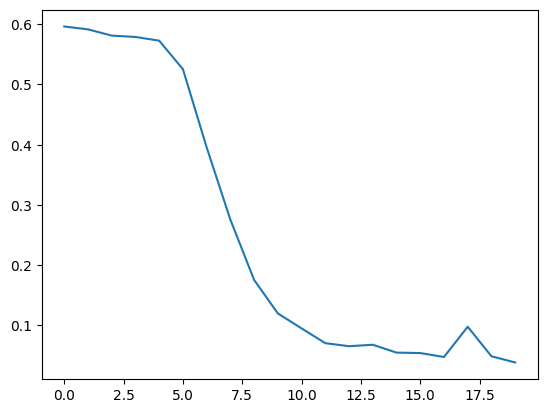

In [34]:
plt.plot(all_losses)

In [44]:
#test on training data
n_correct = 0
n_total = 0
for i in range(n_data_size_test):
    category_tensor, input_sequence = randomTrainingExampleBatch(1,'train',i)
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    output = rnn(input_sequence)
    po=output.argmax(axis=1)
    guess=po.item()
    category = category_tensor
    if category == guess:
        n_correct += 1
    n_total += 1

print('Accuracy of %d test data: %.3f%%' % (n_data_size_test, n_correct / n_total * 100))

Accuracy of 29 test data: 82.759%


In [45]:
#test on testing data

rnn.eval()

n_correct = 0
n_total = 0
for i in range(n_data_size_test):
    category_tensor, input_sequence = randomTrainingExampleBatch(1,'test',i)
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    output = rnn(input_sequence)
    po=output.argmax(axis=1)
    guess=po.item()
    category = category_tensor
    if category == guess:
        n_correct += 1
    n_total += 1

print('Accuracy of %d test data: %.3f%%' % (n_data_size_test, n_correct / n_total * 100))

Accuracy of 29 test data: 89.655%


In [37]:
# torch.save(rnn.state_dict(), 'rnn_train_1_dec7.pth')

### quick test

In [52]:
# test_fn = "/home/cgladu/activitynet-main/clips_eating/extracted_points/ns2_18.mp4_points.txt" 
test_fn = "/home/cgladu/activitynet-main/non_eating_clips/extracted_points/ns1_0_points.txt"

with open(test_fn, 'r') as file:
    lines = np.loadtxt(file, dtype=str)
    ret=[]
    for line in lines:
        frame=[]
        vals = line.split(',')
        for val in vals:
            convert = float(val)
            frame.append(convert)
        ret.append(frame)
    r = np.array(ret)

r.shape

(3461, 50)

In [53]:
Xt=r[:max_length]
Xt.shape

(30, 50)

In [54]:
Xt=torch.from_numpy(Xt).float().to(device)
Xt=Xt.reshape(1, -1, 50)
Xt.shape

torch.Size([1, 30, 50])

In [58]:
logits=rnn(Xt)
po=logits.argmax(axis=1)
po

tensor([0], device='cuda:0')